In [190]:
from helpers import *
from Line import *
import pprint
pp = pprint.PrettyPrinter(indent=4)

TESTIMG = 'test_images/solidWhiteRight.jpg'
img = readImg(TESTIMG)
params = getParams()



%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
# %load lanedetector.py
from helpers import *
from Line import *

def findContours(image, params):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    hsv = getHSV(image)
    bMask = hsv[:,:,2] > params.get("bThresh", 200)
    gray = bMask.astype(np.uint8)*255
    thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)[1]

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    return cnts[1]


def findCentroid(cnt):
    xSum = 0
    ySum = 0
    for pt in cnt:
        pt = pt[0]
        xSum += pt[0]
        ySum += pt[1]
        
    return int(xSum/len(cnt)) , int(ySum/len(cnt))
    
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)

def processSingleLine(gray2, img2, approxLine, lowestY, params):
    linedImg2 = np.zeros_like(gray2)
    #print(linedImg2.shape, img2.shape)
    approxLine.extrapolate(linedImg2, lowestY, params)
    lineMask = cv2.bitwise_and(img2, img2, mask=linedImg2)
    lineMask = cv2.cvtColor(lineMask, cv2.COLOR_BGR2RGB)
    cnts = findContours(lineMask, params)
    if len(cnts) == 1:
        cntroid = findCentroid(cnts[0])
        x1 = cntroid[0] - 15
        y1 = cntroid[1]
        x2 = cntroid[0] + 15
        y2 = cntroid[1]

        cv2.line(linedImg2, (x1, y1) , (x2,y2), color = 0, thickness=10)
        lineMask = cv2.bitwise_and(img2, img2, mask=linedImg2)
        lineMask = cv2.cvtColor(lineMask, cv2.COLOR_BGR2RGB)
        cnts = findContours(lineMask, params)

        assert len(cnts) > 1



    xs = []
    ys = []
    Vals = []

    for cnt in cnts:
        cd = findCentroid(cnt)
        val = (cv2.contourArea(cnt), cd)
        Vals.append(val)
        
        xs.append(cd[0])
        ys.append(cd[1])
        #cv2.circle(outP,(cd[0], cd[1]), 5, (255,0,0), -1)
    
    Vals.sort(key=lambda x: x[0])
    l = Line(Vals[-1][1][0], Vals[-1][1][1], Vals[-2][1][0], Vals[-2][1][1] )
    return l

    def solveForX(z, y):
        return (y - z[1]) / z[0] 

    z1 = np.polyfit(xs, ys, 1)

    lowX = solveForX(z1, img2.shape[0])
    highX = solveForX(z1, int(img2.shape[0]/1.6))

    l = Line(lowX, img2.shape[0], highX, int(img2.shape[0]/1.6))
    
    return l


def detectLanes(img, params):

    blkrSize = params["blurKernalSize"]
    cht = params["cannyHT"]
    clt = params["cannyLT"]
    stage = params["outputStage"]


    hsv = getHSV(img)

    bMask = hsv[:,:,2] > params.get("bThresh", 200)

    if params["useBrightness"]:
        # gray = hsv[:,:,2]
        gray = bMask.astype(np.uint8)*255
    else:
        gray = grayscale(img)

    blur = gaussian_blur(gray, kernel_size=blkrSize)
       
    ht = cht
    lt = clt
    canny_edges = canny(blur, low_threshold=lt, high_threshold=ht)

    #hsv = getHSV(img)
    bMask = cv2.bitwise_and(img, img, mask=bMask.astype(np.uint8))
    bMask = cv2.cvtColor(bMask, cv2.COLOR_BGR2RGB)


    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = params.get("hThresh", 10)
    min_line_length = params.get("hMinLineLen", 20)
    max_line_gap = params.get("hMaxLineGap", 1)

    # houghImg = hough_lines(canny_edges, rho, theta, threshold, min_line_length, max_line_gap)


    hLines = get_hough_lines(canny_edges, rho, theta, threshold, min_line_length, max_line_gap)
    houghImg = draw_hough_lines(canny_edges, hLines)



    lnValsLeft = []
    lnValsRight = []

    for l in hLines:
        ln = LineFromCVLine(l)
        if(ln.isValidLaneCandidate(params)):
                
            lnVal = (540 - max(ln.y1, ln.y2) , ln.length(), ln.slope, ln)
            if(ln.slope < 0):
                lnValsLeft.append(lnVal)
            else:
                lnValsRight.append(lnVal)

    lnValsLeft.sort(key=lambda x: x[0] + 1000/x[1])
    lnValsRight.sort(key=lambda x: x[0] + 1000/x[1])
    #pp.pprint(lnValsLeft)
    #pp.pprint(lnValsRight)

    leftLine = lnValsLeft[0][3]
    rightLine = lnValsRight[0][3]

    linedImg = np.zeros_like(gray)

    finalImg_rough = np.copy(img)

    curY = min(leftLine.y1, leftLine.y2, rightLine.y1, rightLine.y2, int(img.shape[0]/1.6))
    if "minY" not in params:
        params["minY"] = int(img.shape[0]/1.6) 
        # params["minY"] = curY

    delta = curY - params["minY"]
    lowestY = int(params["minY"] + int(0.05* float(delta)))
    params["minY"] = lowestY

    # if "minY" not in params:
    #     params["minY"] = int(img.shape[0]/1.5) 
    #
    # lowestY = min(leftLine.y1, leftLine.y2, rightLine.y1, rightLine.y2, params["minY"])
    # params["minY"] = lowestY

    params["maskLineThickness"] = 5
    
    smoothingRate = 0.05
    
    lSlope = leftLine.slope
    lBias = leftLine.bias
    
    rSlope = rightLine.slope
    rBias = rightLine.bias
    
    curLine = [lSlope, lBias, rSlope, rBias]
    
    if "prevLines" not in params:
        params["prevLines"] = curLine
        
    prevLine = np.array(params["prevLines"])
    curLine = np.array(curLine)
    deltaLine = curLine - prevLine
    finalLine = prevLine + smoothingRate * deltaLine
    
    
    lLine = LineFromSlopeBias(finalLine[0], finalLine[1], lowestY, img.shape[0])
    lLine.draw(finalImg_rough, params)
    
    rLine = LineFromSlopeBias(finalLine[2], finalLine[3], lowestY, img.shape[0])
    rLine.draw(finalImg_rough, params)
    
    #leftLine.extrapolate(finalImg_rough, lowestY, params)
    #rightLine.extrapolate(finalImg_rough, lowestY, params)
    
    
    #
    params["maskLineThickness"] = 15
    leftLine.extrapolate(linedImg, lowestY, params)
    rightLine.extrapolate(linedImg, lowestY, params)

    actualLeft = processSingleLine(gray,img, leftLine, lowestY, params)
    actualRight = processSingleLine(gray,img, rightLine, lowestY, params)
    
    oldVal = params.get("maskLineThickness", 15)
    params["maskLineThickness"] = 2
    # actualLeft.extrapolate(finalImg_rough, lowestY, params)
    # actualRight.extrapolate(finalImg_rough, lowestY, params)
    params["maskLineThickness"] = oldVal

    lineMask = cv2.bitwise_and(img, img, mask=linedImg)
    lineMask = cv2.cvtColor(lineMask, cv2.COLOR_BGR2RGB)

    cnts = findContours(lineMask, params)
    finalImg = np.copy(img)

    cv2.drawContours(finalImg, cnts, -1, (0,255,0), 3)

    outpDict = {
            "final": finalImg_rough,
            "blur": blur,
            "gray": gray,
            "canny": canny_edges,
            "hsv": finalImg_rough,
            "brightness": hsv[:,:,2],
            "hue": hsv[:,:,1],
            "saturation": hsv[:,:,0],
            "bMask": bMask,
            "hough": houghImg,
            "linedImg": linedImg,

    }

    return outpDict[stage]


330


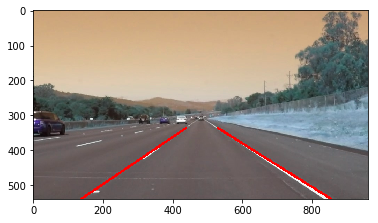

In [208]:
outP = detectLanes(img, params)
showimg(outP)
print(lowestY)
    

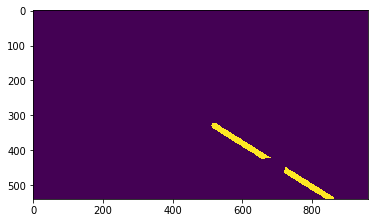

In [182]:
x1 = 680 - 15
y1 = 450
x2 = 680 + 15
y2 = 450
cv2.line(linedImg, (x1, y1) , (x2,y2), color = 0, thickness=51)
showimg(linedImg)


In [ ]:
def findCentroid(cnt):
    xSum = 0
    ySum = 0
    for pt in cnt:
        pt = pt[0]
        xSum += pt[0]
        ySum += pt[1]
        
    return int(xSum/len(cnt)) , int(ySum/len(cnt))
    
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)

#cntroid = findCentroid(cnts[3])
xs = []
ys = []

for cnt in cnts:
    cd = findCentroid(cnt)
    xs.append(cd[0])
    ys.append(cd[1])
    cv2.circle(outP,(cd[0], cd[1]), 5, (255,0,0), -1)
    
def solveForX(z, y):
    return (y - z[1]) / z[0] 
    
z1 = np.polyfit(xs, ys, 1)

lowX = solveForX(z1, 540)
highX = solveForX(z1, 350)

l = Line(lowX, 540, highX, 350)

l.extrapolate(outP, 320, {"maskLineThickness": 5})

showimg(outP)    


In [103]:
img.shape[0]

540

In [20]:

def findContours(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    return cnts[1]
cnts = findContours(lineMask)

#cnts[0]

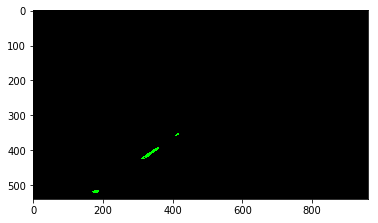

In [21]:
img = readImg(TESTIMG)
img2 = np.zeros_like(img)
imgOut = cv2.drawContours(img2, cnts, -1, (0,255,0), 3)
showimg(img2)

(51.429563482495162, -0.5, 72.0, <Line.Line object at 0x1174d1240>, 419.0, 396.0)
(44.721359549995796, -0.5, 70.0, <Line.Line object at 0x1174d1e48>, 414.0, 394.0)
(40.249223594996216, -0.5, 68.0, <Line.Line object at 0x1174d1e80>, 411.0, 393.0)
(33.541019662496844, -0.5, 66.0, <Line.Line object at 0x1174d1518>, 408.0, 393.0)


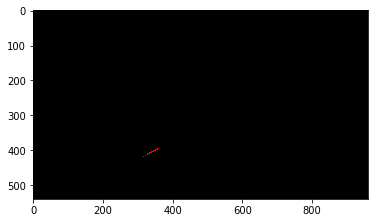

In [22]:
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = np.zeros_like(img)
hLines = get_hough_lines(gray, rho, theta, threshold, min_line_length, max_line_gap)
for l in hLines:
    ln = LineFromCVLine(l)
    if(ln.isValidLaneCandidate(params)):
        ln.draw(img3, thickness=1)
        lnVal = (ln.length(), ln.slope, ln.solveForX(540) , ln, ln.y1, ln.y2)
        print(lnVal)
showimg(img3)

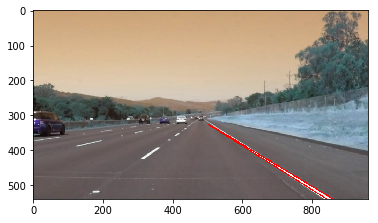

In [7]:
dist = 400
x1 = 842
x2 = 860
s1 = 0.6269430051813472
s2 = 0.6007604562737643
theta1 = np.arctan(s1)
theta2 = np.arctan(s2)

x1High = x1 - dist*np.cos(theta1)
y1High = 540 - dist*np.sin(theta1)

x2High = x2 - dist*np.cos(theta2)
y2High = 540 - dist*np.sin(theta2)

lLeft = Line(x1,540,x1High, y1High)
lRight = Line(x2,540,x2High, y2High)

img = readImg(TESTIMG)
lLeft.draw(img, thickness=2)
lRight.draw(img, thickness=2)
showimg(img)

In [8]:
l = LineFromCVLine(hLines[0])

In [9]:
l = lnValsRight[0][3]
l.highPoint, l.lowPoint, l.slope

AttributeError: 'Line' object has no attribute 'highPoint'

In [10]:
theta = np.arctan(l.slope)
np.sin(theta) / np.cos(theta)

0.62462462462462465

In [11]:
distBwHighLow = l.distBetween(l.lowPoint[0], l.highPoint[0], l.lowPoint[1], l.highPoint[1])
distBwHighLow = np.sqrt(distBwHighLow)
distBwHighLow *= 0.2
distBwHighLow

AttributeError: 'Line' object has no attribute 'lowPoint'

In [12]:
midX = int(l.lowPoint[0] - distBwHighLow*np.cos(theta))
midY = int(l.lowPoint[1] - distBwHighLow*np.sin(theta))
midX, midY

AttributeError: 'Line' object has no attribute 'lowPoint'

In [13]:
delta = 40
br = hsv[midY-delta:midY+delta,midX-delta:midX+delta,2]
showimg(br)

NameError: name 'midY' is not defined

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(distFact=(-1.0,2.0,0.1), delta=(5,200,2))
def getLaneImg(distFact ,delta):
    distBwHighLow = l.distBetween(l.lowPoint[0], l.highPoint[0], l.lowPoint[1], l.highPoint[1])
    distBwHighLow = np.sqrt(distBwHighLow)
    distBwHighLow *= distFact
    midX = int(l.lowPoint[0] - distBwHighLow*np.cos(theta))
    midY = int(l.lowPoint[1] - distBwHighLow*np.sin(theta))
    br = hsv[midY-delta:midY+delta,midX-delta:midX+delta,2]
    plt.imshow(br)
    plt.show()
    print(delta)
    

A Jupyter Widget

In [169]:
br = hsv[:,:,2]
delta = 10
preVal = int(br[midY, midX-delta])
for i in range(midX-delta+1, midX+delta):
    print(i-midX, br[midY,i] , (preVal -  int(br[midY,i])) )
    preVal = br[midY,i]

(-9, 108, 0)
(-8, 105, 3)
(-7, 105, 0)
(-6, 106, -1)
(-5, 103, 3)
(-4, 112, -9)
(-3, 139, -27)
(-2, 179, -40)
(-1, 205, -26)
(0, 210, -5)
(1, 197, 13)
(2, 172, 25)
(3, 136, 36)
(4, 113, 23)
(5, 106, 7)
(6, 111, -5)
(7, 110, 1)
(8, 108, 2)
(9, 111, -3)
